<a href="https://colab.research.google.com/github/yiit8/Vehicle-detection/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
checkpoint = torch.load("/content/drive/MyDrive/VehicleDetection.pth",map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [26]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.6
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

In [19]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [21]:
classes= {0:'auto',1:'bus',2:'car',3:'lcv',4:'motorcycle',5:'multiaxle',6:'tractor',7:'truck'} 

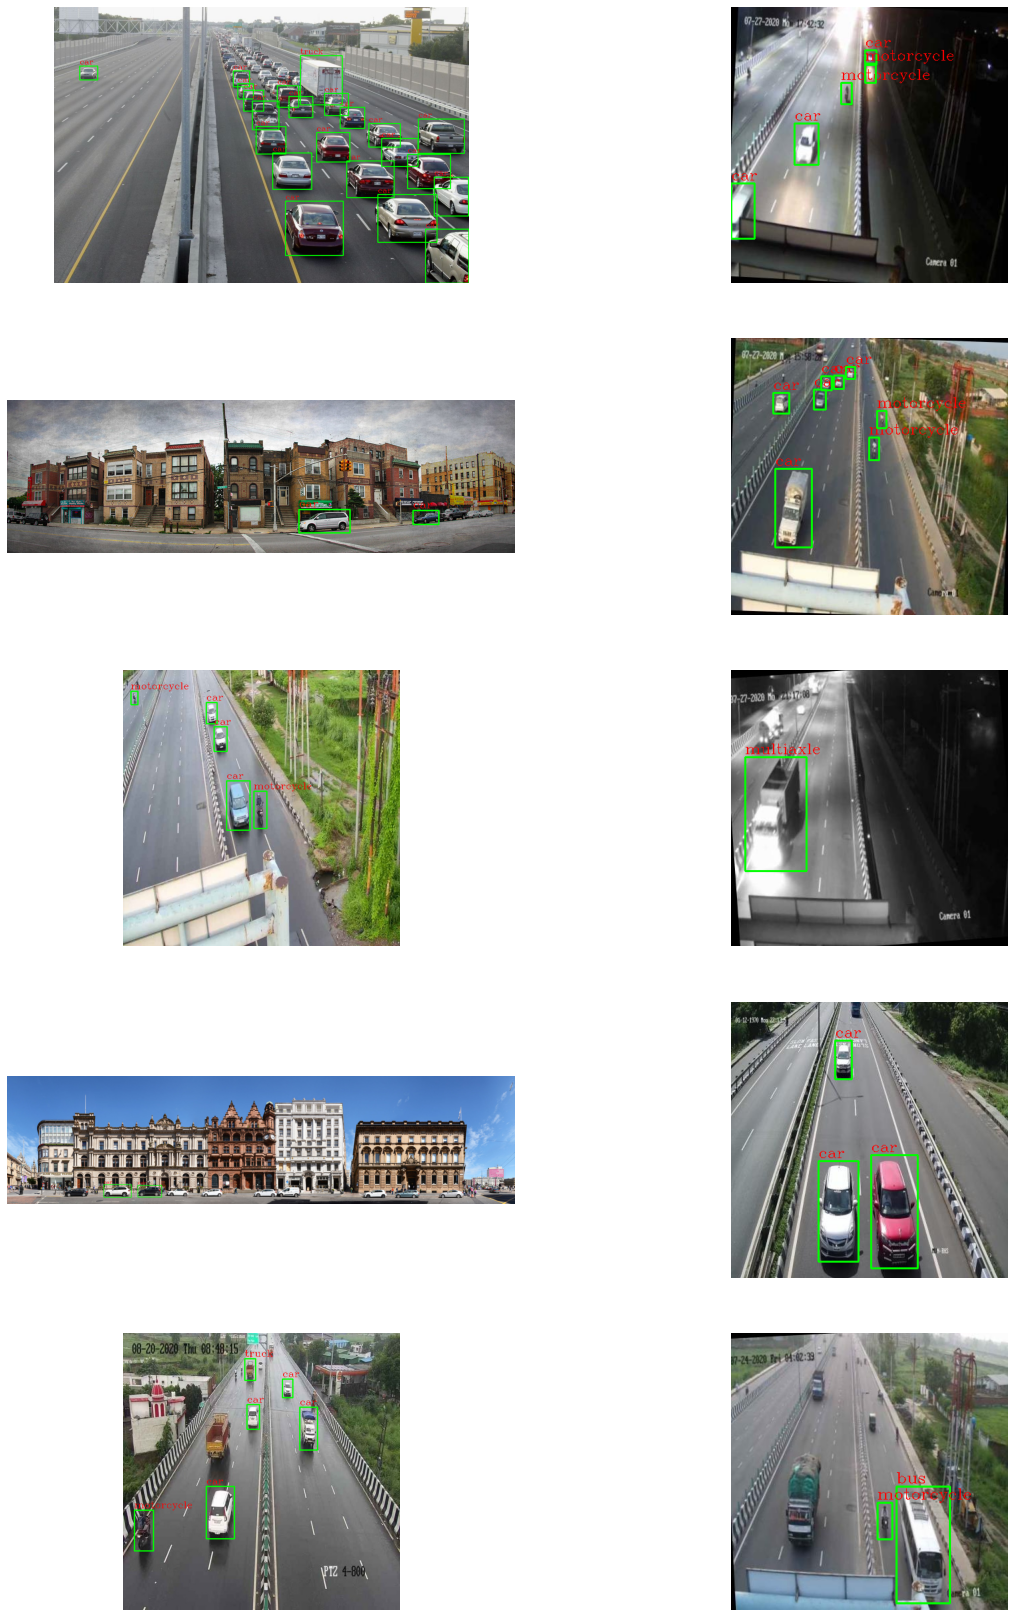

In [27]:
#Testing on Validation Images
pred_path = "/content/test"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)